# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. S8: maps of model resolution

In [1]:
import sys
import os
import numpy as np
from scipy.interpolate import griddata
from netCDF4 import Dataset, MFDataset
import pandas as pd
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.path as mpath
import copy
from numpy.ma import masked_array

In [3]:
#------
# general info
#------

# path to masks of MPAs and ice-shelf cavities (on regular mesh; resolution currently hard-coded to be 0.025deg) 
# -> for contours only (can be easily turned off within plotting functions)
path_to_mask = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/FigS8_model_resolution/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat_model      = f1.variables['lat'][:]
lon_model      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat_model.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]

res = np.sqrt(area)/1000.
print('Min/Max resolution:',np.min(res),np.max(res))


(72411,)
Min/Max resolution: 1.7032297 293.28876


In [4]:
#----
# define lat/lon -> plot map on regular mesh
#----

grid_resolution_x = 0.1  #0.25 # define grid resolution of regular mesh
grid_resolution_y = 0.1 #0.0625
xi = np.arange(-180,180+grid_resolution_x,grid_resolution_x) #longitude
yi = np.arange(-90,40+grid_resolution_y,grid_resolution_y) #latitude

print ('Min/Max lon:',np.min(xi),np.max(xi))
print ('Min/Max lat:',np.min(yi),np.max(yi))
x_all,y_all = np.meshgrid(xi,yi)

print(x_all.shape)


Min/Max lon: -180.0 179.99999999997954
Min/Max lat: -90.0 39.99999999999261
(1301, 3601)


In [6]:
####
# 1) interpolate
# 

lat_orig,lon_orig = lat_model,lon_model

def interpolate_fields(lat_orig,lon_orig,data,lat_final,lon_final):
    interp_method = 'cubic' # cubic, nearest, linear
    data_int = griddata((lon_orig,lat_orig),data,\
                (lon_final.ravel(), lat_final.ravel()), method=interp_method)  # Final interpolated field
    data_int = data_int.reshape((lon_final.shape[0],lon_final.shape[1])) 
    return data_int
    
#--------
print ('regrid resolution')
res_int = interpolate_fields(lat_orig,lon_orig,res,y_all,x_all)
#---------
print ('regrid topo')
topo_int = interpolate_fields(lat_orig,lon_orig,topo,y_all,x_all)
#--------
print ('regrid cavity info')
cav_int = interpolate_fields(lat_orig,lon_orig,cavities,y_all,x_all)
#--------
print ('done')


regrid resolution
regrid topo
regrid cavity info
done


In [7]:
#----
# prepare data to plot
#----

data_res = np.copy(res_int)
data_topo = np.copy(topo_int)
data_cav = np.copy(cav_int)

# topo & sea ice
def correct_dateline_points(data):
    # for topo & sea ice: correct a few more longitudes to get smooth contour lines across the dateline
    data[:,3] = data[:,4]
    data[:,2] = data[:,3]
    data[:,1] = data[:,2]
    data[:,0] = data[:,1]
    data[:,-4] = data[:,-5]
    data[:,-3] = data[:,-4]
    data[:,-2] = data[:,-3]
    data[:,-1] = data[:,-2]
    return data
    
data_topo = correct_dateline_points(data_topo)

data_cav[:,1] = data_cav[:,2]
data_cav[:,0] = data_cav[:,1]
data_cav[:,-2] = data_cav[:,-3]
data_cav[:,-1] = data_cav[:,-2]

data_res2, lon = add_cyclic_point(data_res, coord=xi)

data2, lonxx = add_cyclic_point(data_topo, coord=xi)
del lonxx
data3, lonxx = add_cyclic_point(data_cav, coord=xi)
del lonxx
print (data2.shape)
print (data3.shape)


#----
# correct data in cavity etc
#----

# correct topo data on land
data2[data2<0]=-999
data2[np.isnan(data2)]=-999

# cavity field
data3[data3<0]=-999
data3[np.isnan(data3)]=-999

data2[data3>=0.5]=-999
print ('done')


(1301, 3602)
(1301, 3602)
done


In [8]:
#----
# plotting function
#-----

color_cavity ='darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar(data_plot,lon_plot,lat_plot,levels1,cmap1,clabel_string,\
                         topo_int,save_plots,display_plots,savepath,filename1,path_to_mask):
    plot_colorbar = False
    fs = 10
    
    plot_MPAs = True
    color_mpa = 'k'
    lw_mpa = 2
    
    if min(levels1)==-8:
        cticks = [-8,-6,-4,-2,0,2,4,6,8]
    elif min(levels1)==-4:
        cticks = [-4,-3,-2,-1,0,1,2,3,4]
    elif min(levels1)==-3:
        cticks = [-3,-2,-1,0,1,2,3]
    elif min(levels1)==-2:
        cticks = [-2,-1,0,1,2]
    elif max(levels1)==10: # NPP
        cticks = [0,2,4,6,8,10]
    else:
        cticks = levels1[0::10]

    # projection
    projection=ccrs.SouthPolarStereo()
    
    if plot_MPAs:
        which_res = '0.025'

        f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
        mask_WAP_MPA = f1.variables['mask_mpa'][:]
        lon_MPA2 = f1.variables['lon'][:]
        lat_MPA2 = f1.variables['lat'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA1_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA2_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA3_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_Orkney_regular_mesh_'+which_res+'deg.nc')
        mask_Orkney_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_RossSea_regular_mesh_'+which_res+'deg.nc')
        mask_RossSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_regular_mesh_'+which_res+'deg.nc')
        mask_WeddellSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()

        f1 = Dataset(path_to_mask+'Mask_cavities_regular_mesh_'+which_res+'deg.nc')
        cav_int = f1.variables['mask_cavities'][:]
        f1.close()
        
        cav_int[cav_int.mask==True]=0

        mask_eastAA1_MPA[mask_eastAA1_MPA.mask==True]=0 #np.ma.masked_where()
        mask_eastAA2_MPA[mask_eastAA2_MPA.mask==True]=0
        mask_eastAA3_MPA[mask_eastAA3_MPA.mask==True]=0
        mask_WeddellSea_MPA[mask_WeddellSea_MPA.mask==True]=0
        mask_Orkney_MPA[mask_Orkney_MPA.mask==True]=0
        mask_RossSea_MPA[mask_RossSea_MPA.mask==True]=0
        mask_WAP_MPA[mask_WAP_MPA.mask==True]=0
        
        lon_MPA,lat_MPA = np.meshgrid(lon_MPA2,lat_MPA2)
        del lon_MPA2,lat_MPA2
            
        # correct mask so that it matches the mask used on FESOM mesh (see regrid_cavity_to_regular_mesh.ipynb)
        # for the Weddell Sea, connect piece at WAP tip with southern piece
        ind = np.where((lat_MPA<=-64.0) & (lon_MPA<-50) & (lon_MPA>-62.5)) #[0]
        # ind = np.where((lat_MPA<=-64.0) & (lon_MPA<310) & (lon_MPA>298.5)) #[0]
        mask_WeddellSea_MPA[ind]=1
        # correct piece that reaches into WAP
        ind = np.where((lat_MPA>-64.8) & (lon_MPA<-60)) #[0]
        # ind = np.where((lat_MPA >-64.8) & (lon_MPA<300)) #[0]
        mask_WeddellSea_MPA[ind]=0
            
        mask_eastAA1_MPA[cav_int==1]=0
        mask_eastAA2_MPA[cav_int==1]=0
        mask_eastAA3_MPA[cav_int==1]=0
        mask_WeddellSea_MPA[cav_int==1]=0
        mask_Orkney_MPA[cav_int==1]=0
        mask_RossSea_MPA[cav_int==1]=0
        mask_WAP_MPA[cav_int==1]=0
        
        print('min/max mask_MPA:',np.min(mask_WeddellSea_MPA),np.max(mask_WeddellSea_MPA))
        
    
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    mm1=ax.contourf(lon_plot, lat_plot, data_plot,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.7,ticks=cticks)
        cbar.set_label(clabel_string,fontsize=fs+6)
        cbar.ax.tick_params(labelsize=fs+5)
        
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-65])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    lw = 2
    ax.contour(lon_plot, lat_plot, topo_int,levels = [2000],\
                     colors=['dimgrey','black','black'],linewidths=[lw,lw,lw],\
               linestyles=['-','-',':'],transform=ccrs.PlateCarree())
    
    #-----
    # add MPA contours
    if plot_MPAs:
        ax.contour(lon_MPA, lat_MPA, mask_WeddellSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_WAP_MPA,levels = [lw_mpa],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_RossSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA1_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA2_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA3_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_Orkney_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        
        # cavities
        ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
                         colors=['gainsboro'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    #-----
    
    dpicnt = 200

    if save_plots:
        if plot_colorbar:
            filename = filename1+'.png'
        else:
            filename = filename1+'_no_colorbar.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
            

        

min/max mask_MPA: 0.0 1.0


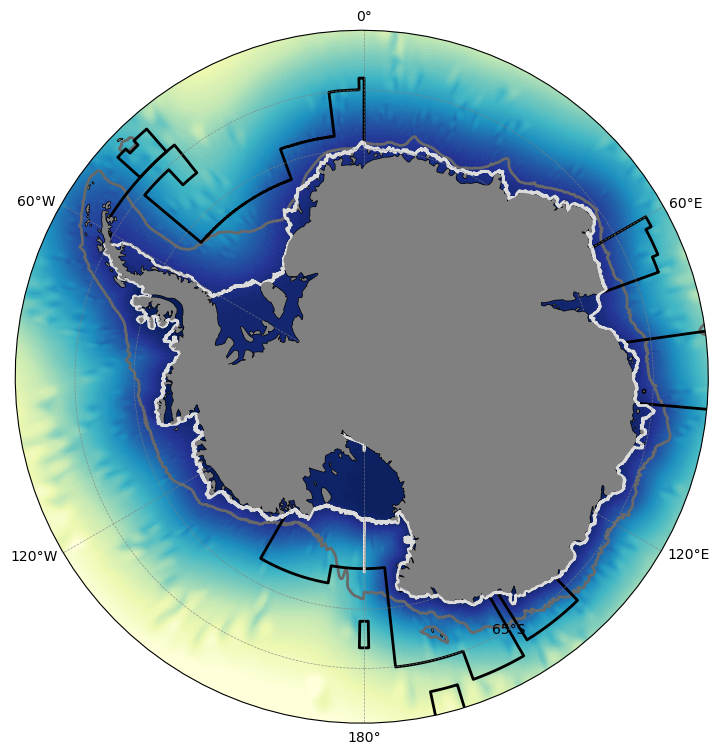

In [10]:
#----
# plot: resolution
#----

save_plots = True
display_plots = True
lon_plot,lat_plot = np.meshgrid(lon,yi)  

# colormap
cmap1 = copy.copy(plt.cm.YlGnBu_r) #RdBu_r

levels1   = np.arange(2,150+2,2)

data_plot = np.copy(data_res2)
#data_plot[data3>=0.8]=999 # mask cavities
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)

nn = 5
data_plot[:,4]  = data_plot[:,nn]
data_plot[:,3]  = data_plot[:,nn]
data_plot[:,2]  = data_plot[:,nn]
data_plot[:,1]  = data_plot[:,nn]
data_plot[:,0]  = data_plot[:,nn]

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]
        
clabel_string = 'Grid resolution in km'
filename = 'Map_grid_resolution'      
plot_map_circumpolar(data_plot,lon_plot,lat_plot,\
                     levels1,cmap1,clabel_string,data2,save_plots,display_plots,savepath,filename,path_to_mask)


In [ ]:
#----
# save colorbars only
#----

In [11]:
  
def plot_map_circumpolar_colorbar_only(data_plot,lon_plot,lat_plot,levels1,cmap1,clabel_string,\
                         topo_int,save_plots,display_plots,savepath,filename1):
    
    fs = 10
    
    if min(levels1)==-8:
        cticks = [-8,-6,-4,-2,0,2,4,6,8]
    elif min(levels1)==-4:
        cticks = [-4,-3,-2,-1,0,1,2,3,4]
    elif min(levels1)==-3:
        cticks = [-3,-2,-1,0,1,2,3]
    elif min(levels1)==-2:
        cticks = [-2,-1,0,1,2]
    elif max(levels1)==10: # NPP
        cticks = [0,2,4,6,8,10]
    else:
        cticks = levels1[0::10]
    cticks = [2,10,25,50,75,100,125,150]

    # projection
    projection=ccrs.SouthPolarStereo()
    
    #----
    # save as eps
    #----
    print('eps...')
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    mm1=ax.contourf(lon_plot, lat_plot, data_plot,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    
    plt.gca().set_visible(False)
    
    cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.7,ticks=cticks)
    cbar.ax.tick_params(labelsize=fs+5)
    #cbar.set_ticks(cticks)
    cbar.ax.set_xticklabels(['']*len(cticks))#np.repeat('',len(cticks)))
        
    dpicnt = 200

    if save_plots:
        plt.savefig(savepath+filename1+'_colorbar_only.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
        
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #---
    # save as png
    #---
    print('png...')
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    mm1=ax.contourf(lon_plot, lat_plot, data_plot,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    
    plt.gca().set_visible(False)
    
    cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.7,ticks=cticks)
    cbar.set_label(clabel_string,fontsize=fs+6)
    cbar.ax.tick_params(labelsize=fs+5)
    
    dpicnt = 200

    if save_plots:
        plt.savefig(savepath+filename1+'_colorbar_only.png',dpi = dpicnt, bbox_inches='tight')
        
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        

eps...


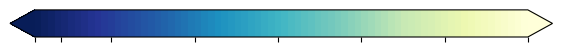

png...


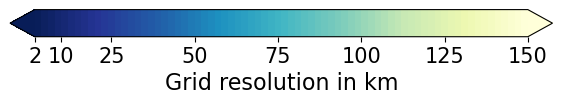

In [12]:
#----
# plot:model resolution, COLORBAR ONLY
#----

levels1   = np.arange(2,150+2,2)

data_plot = np.copy(data_res2)
#data_plot[data3>=0.8]=999 # mask cavities
data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)

nn = 5
data_plot[:,4]  = data_plot[:,nn]
data_plot[:,3]  = data_plot[:,nn]
data_plot[:,2]  = data_plot[:,nn]
data_plot[:,1]  = data_plot[:,nn]
data_plot[:,0]  = data_plot[:,nn]

data_plot[:,-1] = data_plot[:,1]
data_plot[:,-2] = data_plot[:,1]
data_plot[:,-3] = data_plot[:,1]
data_plot[:,-4] = data_plot[:,1]
        
clabel_string = 'Grid resolution in km'
filename = 'Map_grid_resolution'     
plot_map_circumpolar_colorbar_only(data_plot,lon_plot,lat_plot,\
                     levels1,cmap1,clabel_string,data2,save_plots,display_plots,savepath,filename)
